In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from normalizer import Normalizer
from results import ModelEvaluation

In [23]:

data = pd.read_csv("../FinalModels/datasets/NewsHeadlines.csv")
texts= data["text"]
labels = data["label"]
results = ModelEvaluation()


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  20000 non-null  int64 
 1   text        20000 non-null  object
 2   label       20000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 468.9+ KB


In [25]:
tokenizer = Tokenizer(num_words=10000)  # Adjust num_words to fit your vocab size
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Define a max sequence length (or use the length of the longest sequence)
max_seq_length = max([len(seq) for seq in sequences])
X = pad_sequences(sequences, maxlen=max_seq_length, padding='post')


In [26]:
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=max_seq_length))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 35, 128)           1280000   
                                                                 
 bidirectional_2 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable params: 1378945 (5.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)
history = model.fit(X_train, y_train, epochs=3, batch_size=32, validation_split=0.10)  # Adjust epochs, batch_size, and validation_split as needed


Epoch 1/3
450/450 [==============================] - 11s 19ms/step - loss: 0.4186 - accuracy: 0.8019 - val_loss: 0.3383 - val_accuracy: 0.8506
Epoch 2/3
450/450 [==============================] - 9s 20ms/step - loss: 0.2168 - accuracy: 0.9124 - val_loss: 0.3481 - val_accuracy: 0.8512
Epoch 3/3
450/450 [==============================] - 9s 20ms/step - loss: 0.1189 - accuracy: 0.9556 - val_loss: 0.4588 - val_accuracy: 0.8413


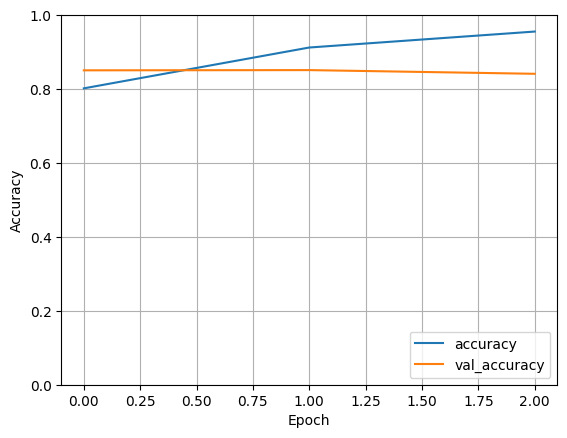

In [28]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.grid()
plt.show()

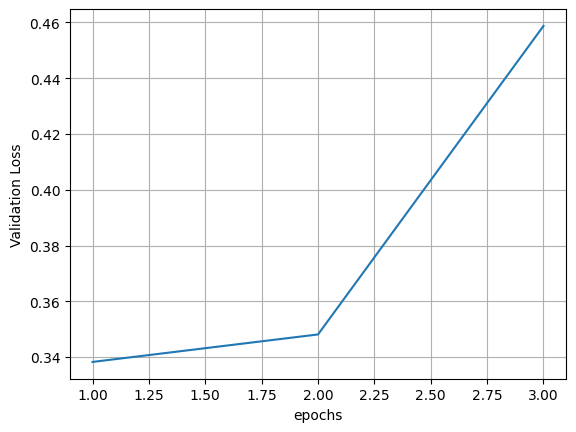

In [29]:
losses = history.history["val_loss"]
plt.plot(range(1,4), losses)
plt.xlabel("epochs")
plt.ylabel("Validation Loss")
plt.grid()
plt.show()


In [30]:
y_pred = model.predict(X_test)

y_pred_class = (y_pred >= 0.5).astype(int)
results.classification_report(y_test, y_pred_class)

125/125 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      2000
           1       0.85      0.85      0.85      2000

    accuracy                           0.85      4000
   macro avg       0.85      0.85      0.85      4000
weighted avg       0.85      0.85      0.85      4000



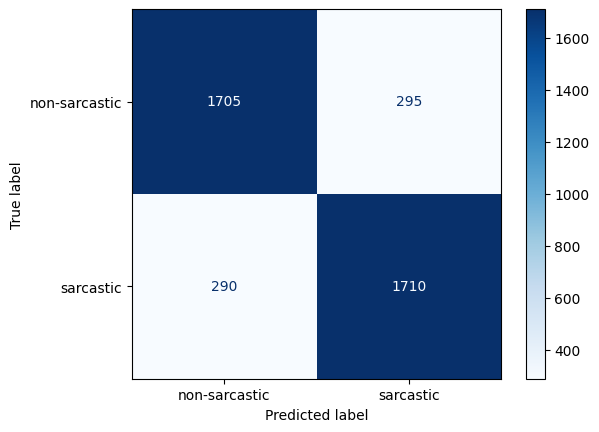

In [31]:
results.get_cm(y_true=y_test, y_pred=y_pred_class)

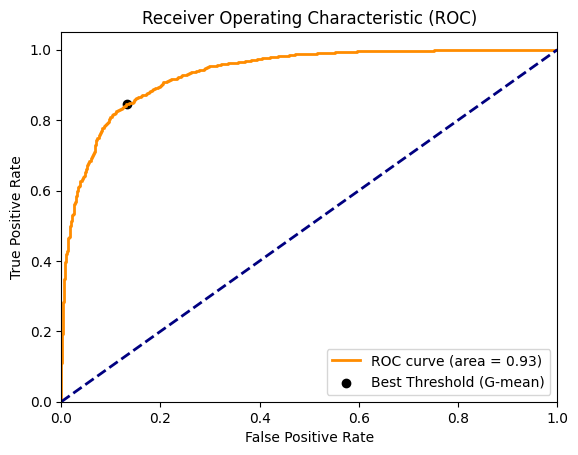

Best Threshold=0.5788


In [32]:
threshold = results.get_roc(y_test, y_pred)